In [1]:
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd


In [11]:
from utils import make_bb
import globals
globals.initialize()
from config import *

In [13]:
flare_ref_pos = globals.flare_ref_pos
flr_id = globals.flareid

filters = ['u', 'g', 'r', 'i', 'z', 'y']

filtercolors = {
            "u": "#66CCEE",
            "g": "#228833",
            "r": "#CCBB44",
            "i": "#EE6677",
            "z": "#AA3377",
            "y": "#4B3713",
            " ": None}

In [78]:
#sets points within the flare in finds and outside in !finds
baseline_npoints = 700 #seconds since the start
baseline = np.nanmean(delta_g_mag[tSec - tSec[0] < baseline_npoints])
var = np.nanstd(delta_g_mag[tSec - tSec[0] < baseline_npoints])
tPeak = np.where(abs(delta_g_mag) == np.nanmax(abs(delta_g_mag)))[0][0] #only apply rate cap on post-peak evolution
finds = (delta_g_mag < baseline - 3 * var)
tflare0 = np.where(finds)[0][0] # index of the first flare point 
finds[tflare0:] = True
finds

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [40]:
flr_weffs = pd.read_csv('Outdata/flr_weffs.csv', header=None).values.flatten()
weffErrRadec = np.load('Outdata/weffErrRadec.npy')


In [32]:
# Read in data for analysis
dpar_arr = np.load('Outdata/dpar_arr.npy')
dpar_raw = np.load('Outdata/dpar_raw.npy')
dpar_subtracted = np.load('Outdata/dpar_subtracted.npy')
dpar_smoothed = np.load('Outdata/dpar_smoothed.npy')
dparerr_smoothed = np.load('Outdata/dparerr_smoothed.npy')
dparerr = np.load('Outdata/dparerr.npy')
delta_g_mag = np.load('Outdata/delta_g_mag.npy')
delta_g_mag_err = np.load('Outdata/delta_g_mag_err.npy')
ras = np.load('Outdata/ras.npy')
decs = np.load('Outdata/decs.npy')
raerrs = np.load('Outdata/raerrs.npy')
decerrs = np.load('Outdata/decerrs.npy')
times = np.load('Outdata/times.npy')
dt_sec = np.load('Outdata/dt_sec.npy')
imnames_timeordered = np.load('Outdata/imnames_timeordered.npy')
imnames_timeordered_S18 = np.load('Outdata/imnames_timeordered_S18.npy')

# Dataframe version
useDF = True
if useDF:
    flare_df = pd.read_csv("Outdata/flare_df.csv", index_col=0)
    flare_astrometry = pd.read_csv("Outdata/main_df_GaussPSF.csv")

    # Ensure the 'mjd' and 'time' columns are rounded to avoid floating point precision issues during merge
    flare_df['mjd'] = flare_df['mjd'].round(10)
    flare_astrometry['time'] = flare_astrometry['time'].round(10)

    flare_info = flare_df[['mjd', 'time', 'dpar_smoothed', 'dparerr_smoothed', 'g_mag', 'g_mag_error', 'am']].merge(
        flare_astrometry[['RA', 'DEC', 'RA_ERR', 'DEC_ERR', 'time']][flare_astrometry['id'] == flr_id], left_on="mjd", right_on="time")

    flare_info.drop('time_y', axis=1, inplace=True)  # Drop the duplicate 'time' column from astrometry
    dpar_smoothed = flare_info['dpar_smoothed'].values
    dparerr_smoothed = flare_info['dparerr_smoothed'].values
    ras = flare_info['RA'].values
    decs = flare_info['DEC'].values
    raerrs = flare_info['RA_ERR'].values
    decerrs = flare_info['DEC_ERR'].values
    times = flare_info['mjd'].values
    delta_g_mag = flare_info['g_mag'].values
    delta_g_mag_err = flare_info['g_mag_error'].values
tSec = (times - times[0]) * DAY2SEC

In [120]:
flr_teffs = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}
flr_ffs = {"Scenario1":{}, "Scenario2":{}, "Scenario3":{}}
flr_teff_errs = pd.read_csv("Outdata/flr_teff_errsScenario1.csv")["nolines"]
flr_ff_errs = pd.read_csv("Outdata/flr_ff_errsScenario1.csv")["nolines"]

for i in [1,2,3]:
    flr_teffs[f"Scenario{i}"]["lines"] = np.load(f'Outdata/flr_teffs{i}_lines.npy')
    flr_teffs[f"Scenario{i}"]["nolines"] = np.load(f'Outdata/flr_teffs{i}_nolines.npy') 
    flr_ffs[f"Scenario{i}"]["lines"] = np.load(f'Outdata/flr_ffs{i}_lines.npy')
    flr_ffs[f"Scenario{i}"]["nolines"] = np.load(f'Outdata/flr_ffs{i}_nolines.npy') 



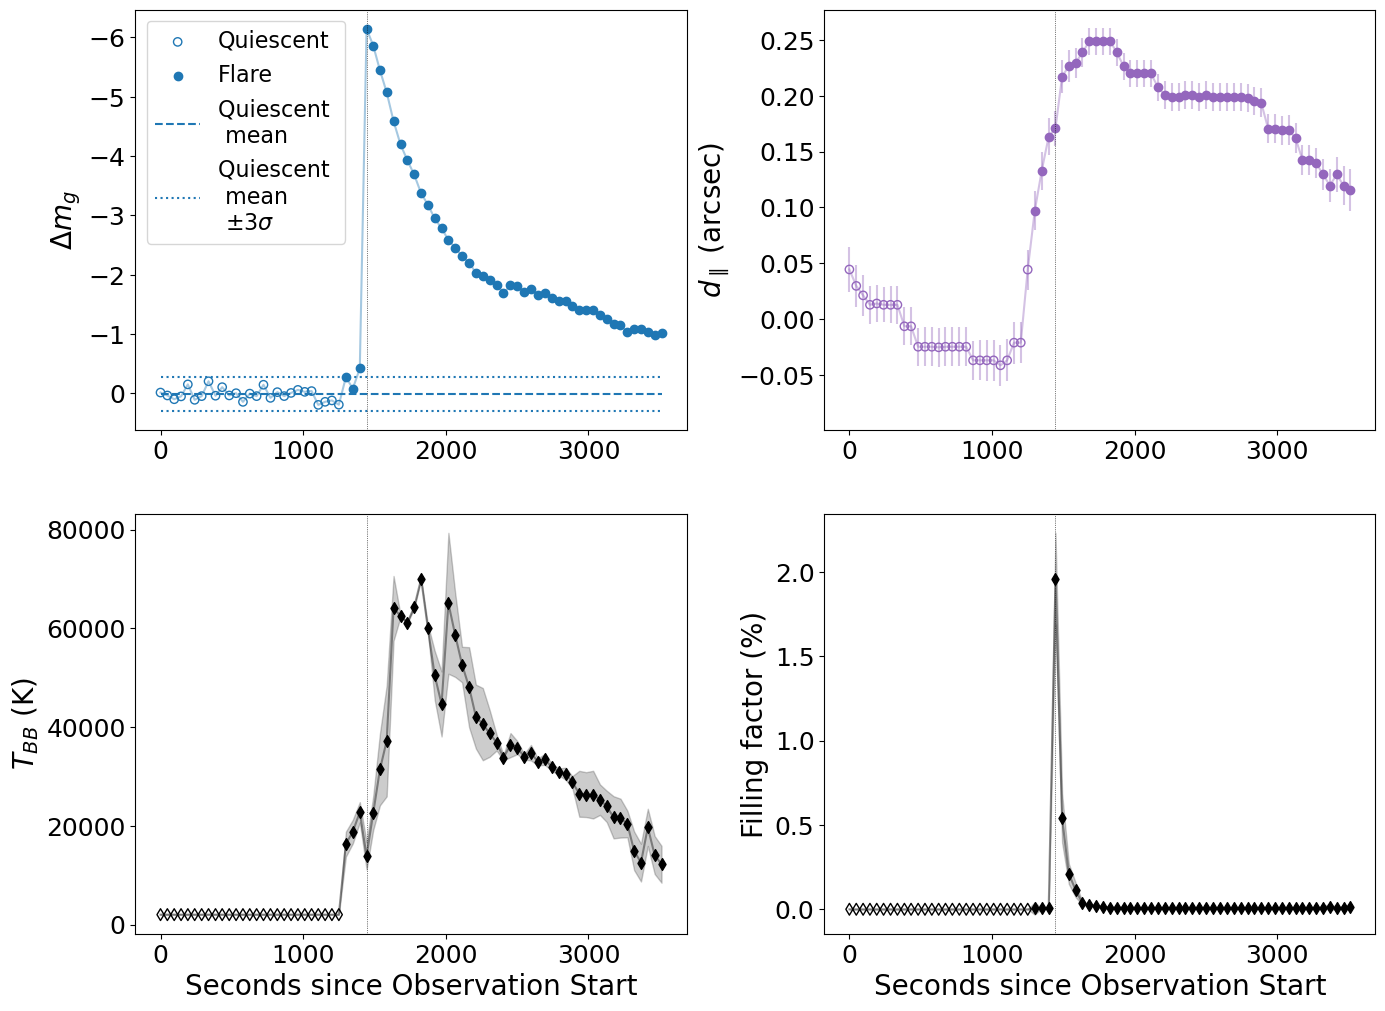

In [121]:
fig, axes = plt.subplots(2,2,figsize=(16,12))
fig.subplots_adjust(wspace=0.25)
ax = axes.flatten()


ax[0].scatter(tSec[~finds], delta_g_mag[~finds], edgecolor='C0', facecolor='None', label='Quiescent')
ax[0].scatter(tSec[finds], delta_g_mag[finds], c='C0', label='Flare')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]), 0, tSec[-1], color='C0', ls='--', 
             label='Quiescent \n mean')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) - 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 3, 0, tSec[-1], color='C0', ls=':', 
             label='Quiescent \n mean \n '+r'$\pm$'+r'3$\sigma$')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) + 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 3, 0, tSec[-1], color='C0', ls=':')
ax[0].plot(tSec, delta_g_mag, c='C0', alpha=0.4)
ax[0].set_ylabel(r'$\Delta m_g$')
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')
ax[0].legend(loc='upper left', fontsize=16)

ax[1].errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, alpha=0.4, color='C4', ls='None')
ax[1].scatter(tSec[~finds], dpar_smoothed[~finds], edgecolor='C4', facecolor='None')
ax[1].scatter(tSec[finds], dpar_smoothed[finds], c='C4')
ax[1].plot(tSec, dpar_smoothed, c='C4', alpha=0.4)
ax[1].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')
ax[1].set_ylim(-0.099, None)
ax[1].set_ylabel(r'$d_{\parallel}$ (arcsec)')


ax[2].scatter(tSec[~finds], flr_teffs[f"Scenario1"]["nolines"][~finds], edgecolor='k', marker='d', facecolor='None')
ax[2].scatter(tSec[finds], flr_teffs[f"Scenario1"]["nolines"][finds], c='k', marker='d')
ax[2].fill_between(tSec, flr_teffs[f"Scenario1"]["nolines"] + flr_teff_errs, 
                   flr_teffs[f"Scenario1"]["nolines"] - flr_teff_errs, color="k", alpha=0.2)
ax[2].plot(tSec, flr_teffs[f"Scenario1"]["nolines"], c='k', alpha=0.4, ls='-')
ax[2].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')
ax[2].set_xlabel('Seconds since Observation Start')
ax[2].set_ylabel(r'$T_{BB}$ (K)')

ax[3].scatter(tSec[~finds], flr_ffs[f"Scenario1"]["nolines"][~finds], edgecolor='k', marker='d', facecolor='None')
ax[3].scatter(tSec[finds], flr_ffs[f"Scenario1"]["nolines"][finds], c='k', marker='d')
ax[3].fill_between(tSec, flr_ffs[f"Scenario1"]["nolines"] + flr_ff_errs, 
                   flr_ffs[f"Scenario1"]["nolines"] - flr_ff_errs, color="k", alpha=0.2)
ax[3].plot(tSec, flr_ffs[f"Scenario1"]["nolines"], c='k', alpha=0.4, ls='-')
ax[3].axvline(x=tSec[tPeak], lw=0.5, ls = 'dotted', c='k')
ax[3].set_ylabel('Filling factor (%)')
ax[3].set_xlabel('Seconds since Observation Start')

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=18)
    a.xaxis.get_label().set_fontsize(20)
    a.yaxis.get_label().set_fontsize(20)

fig.savefig('Figures/result_grid_partial.png', bbox_inches='tight')

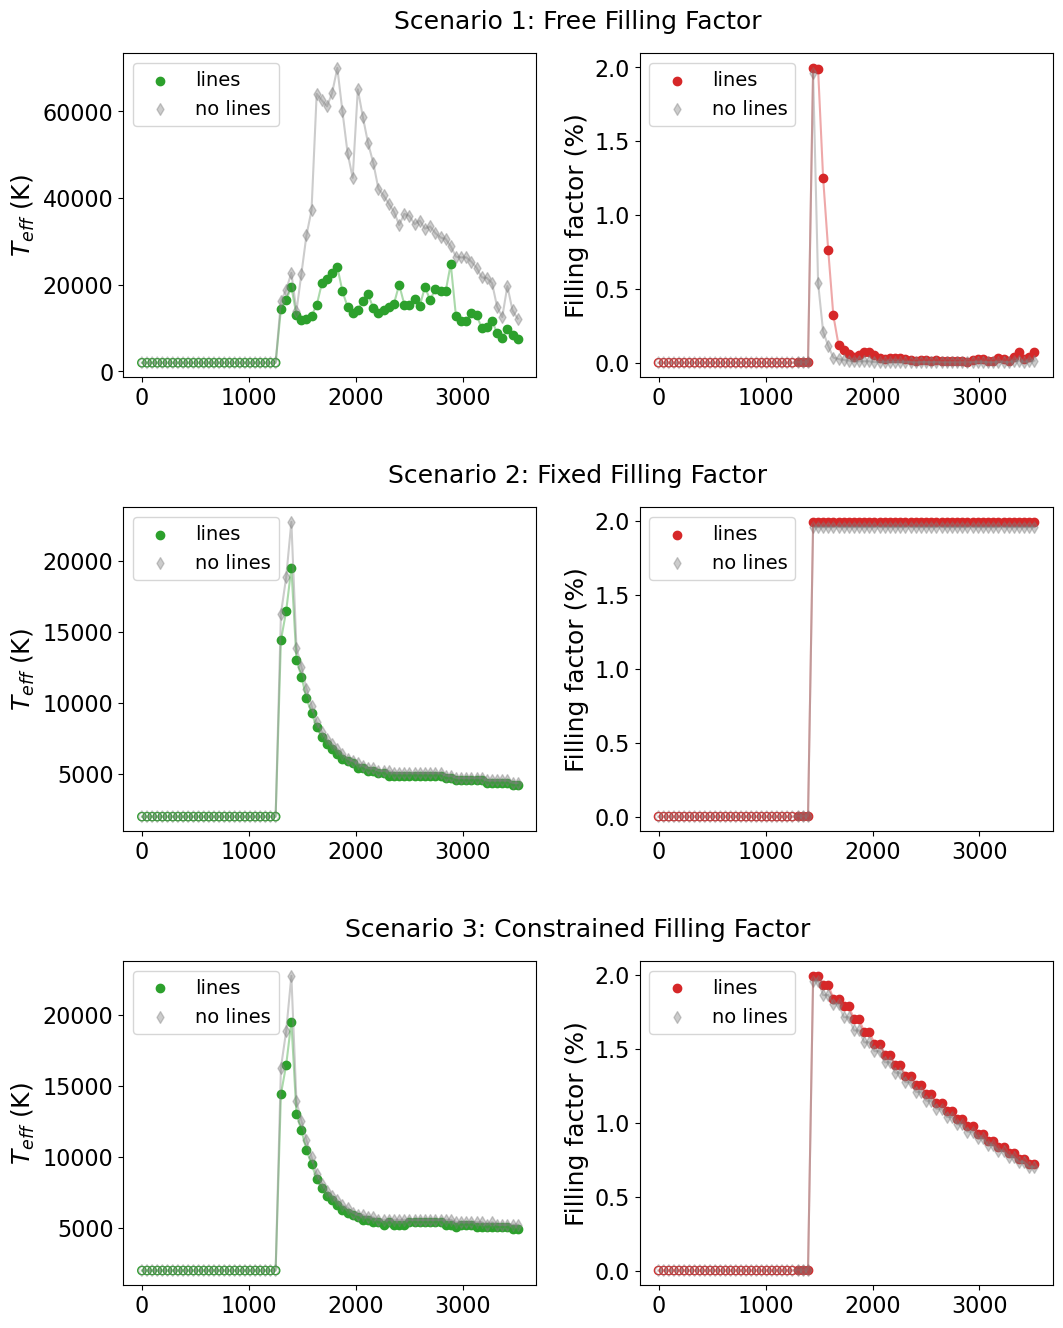

In [127]:
fig, axes = plt.subplots(3,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4, wspace=0.25)
ax = axes.flatten()

for i in range(3):
    j = i * 2
    wline = np.load(f'Outdata/flr_teffs{i+1}_lines.npy')
    wnoline = np.load(f'Outdata/flr_teffs{i+1}_nolines.npy')
    ax[j].scatter(tSec[~finds], wline[~finds], edgecolor='C2', facecolor='None')
    ax[j].scatter(tSec[finds], wline[finds], c='C2', label='lines')
    ax[j].scatter(tSec[~finds], wnoline[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
    ax[j].scatter(tSec[finds], wnoline[finds], c='grey', alpha=0.4, marker='d', label='no lines')
    ax[j].plot(tSec, wline, c='C2', alpha=0.4)
    ax[j].plot(tSec, wnoline, c='grey', ls='-', alpha=0.4)
    ax[j].set_ylabel(r'$T_{eff}$ (K)')
    ax[j].legend()
    
    wline = np.load(f'Outdata/flr_ffs{i+1}_lines.npy')
    wnoline = np.load(f'Outdata/flr_ffs{i+1}_nolines.npy')
    ax[j+1].scatter(tSec[~finds], wline[~finds], edgecolor='C3', facecolor='None')
    ax[j+1].scatter(tSec[finds], wline[finds], c='C3', label='lines')
    ax[j+1].scatter(tSec[~finds], wnoline[~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
    ax[j+1].scatter(tSec[finds], wnoline[finds], c='grey', alpha=0.4, marker='d', label='no lines')
    ax[j+1].plot(tSec, wline, c='C3', alpha=0.4)
    ax[j+1].plot(tSec, wnoline, c='grey', alpha=0.4, ls='-')
    ax[j+1].set_ylabel('Filling factor (%)')
    ax[j+1].legend()


for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)
    a.legend(loc='upper left', fontsize=14)

ax[0].set_title('Scenario 1: Free Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[2].set_title('Scenario 2: Fixed Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[4].set_title('Scenario 3: Constrained Filling Factor', x=1.1, y=1.05, fontsize=18)

fig.savefig('Figures/result_grid_full.png', bbox_inches='tight')

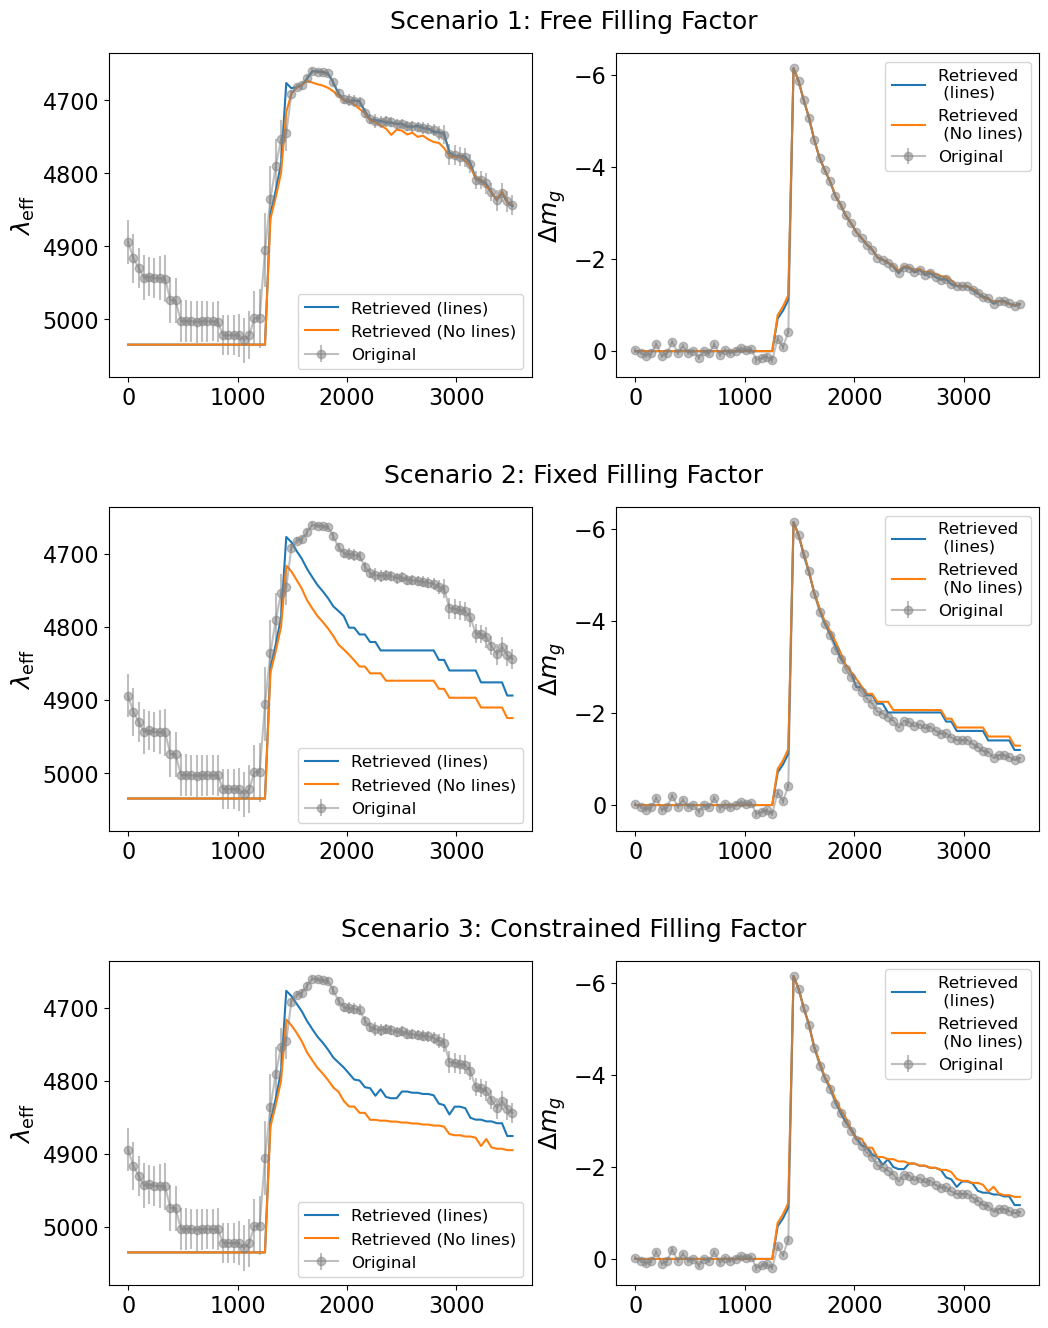

In [124]:
fig, axes = plt.subplots(3,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4)
ax = axes.flatten()
#~finds = np.arange(0,30)
#finds = np.arange(30,74)

for i in range(3):
    j = i * 2
    ax[j].errorbar(tSec, flr_weffs, yerr = weffErrRadec, alpha = 0.5, c='grey', marker='o', label='Original')
    ax[j].plot(tSec, np.load(f'Outdata/retrived_weffs{i+1}_lines.npy'), label='Retrieved (lines)')
    ax[j].plot(tSec, np.load(f'Outdata/retrived_weffs{i+1}_nolines.npy'), label='Retrieved (No lines)')
    ax[j].set_ylabel(r'$\lambda_\mathrm{eff}$')
    ax[j].invert_yaxis()
    ax[j].legend(loc = 'lower right', fontsize=8)
    
    ax[j+1].plot(tSec, np.load(f'Outdata/retrived_mags{i+1}_lines.npy'), label='Retrieved \n (lines)')
    ax[j+1].plot(tSec, np.load(f'Outdata/retrived_mags{i+1}_nolines.npy'), label='Retrieved \n (No lines)')
    ax[j+1].errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err, alpha = 0.5, c='grey', marker='o', label='Original')
    ax[j+1].set_ylabel(r'$\Delta m_g$')
    ax[j+1].invert_yaxis()
    ax[j+1].legend(loc = 'lower right', fontsize=8)
    
    
    ax[0].set_title('Scenario 1: Free Filling Factor', x=1.1, y=1.05, fontsize=18)
    ax[2].set_title('Scenario 2: Fixed Filling Factor', x=1.1, y=1.05, fontsize=18)
    ax[4].set_title('Scenario 3: Constrained Filling Factor', x=1.1, y=1.05, fontsize=18)

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)

    if i % 2 == 0:
        a.legend(loc = 'lower right', fontsize=12)
    else:
        a.legend(loc = 'upper right', fontsize=12)

fig.savefig('Figures/retrieval.png', dpi=300, bbox_inches='tight')

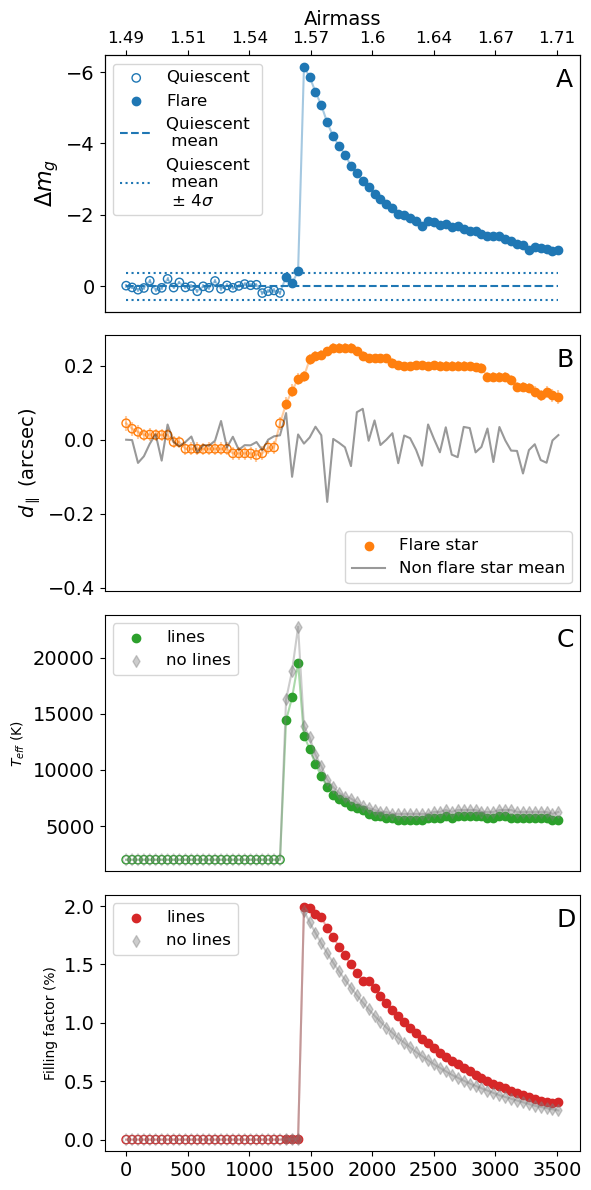

In [43]:
fig, axes = plt.subplots(4,1, figsize=(6,12))

ax = axes.flatten()


magerrs = np.load('Outdata/SEmagerrs.npy')

ax[0].errorbar(tSec, delta_g_mag, yerr = magerrs, alpha=0.4, color='C0', ls='None')
ax[0].scatter(tSec[~finds], delta_g_mag[~finds], edgecolor='C0', facecolor='None', label='Quiescent')
ax[0].scatter(tSec[finds], delta_g_mag[finds], c='C0', label='Flare')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]), 0, tSec[-1], color='C0', ls='--', label='Quiescent \n mean')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) - 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 4, 0, tSec[-1], color='C0', ls=':', label='Quiescent \n mean \n'+r' $\pm$ $4\sigma$')
ax[0].hlines(np.nanmean(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) + 
             np.nanstd(delta_g_mag[:np.where(tSec < baseline_npoints)[0][-1]]) * 4, 0, tSec[-1], color='C0', ls=':')
ax[0].plot(tSec, delta_g_mag, c='C0', alpha=0.4)
ax[0].set_ylabel(r'$\Delta m_g$', fontsize=16)
ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].legend(loc='upper left', fontsize=12)
ax[0].tick_params(axis='both', labelsize=12)

subax0 = ax[0].twiny()
subax0.set_xticks(ax[0].get_xticks())
subax0.set_xticklabels(np.round(AM[::8], decimals=2), fontsize=12)
subax0.set_xlim(ax[0].get_xlim())
subax0.set_xlabel('Airmass', fontsize=14)

ax[1].errorbar(tSec, dpar_smoothed, yerr = dparerr_smoothed, alpha=0.4, color='C1', ls='None')
ax[1].scatter(tSec[~finds], dpar_smoothed[~finds], edgecolor='C1', facecolor='None')
ax[1].scatter(tSec[finds], dpar_smoothed[finds], c='C1', label='Flare star')
ax[1].plot(tSec, dpar_smoothed, c='C1', alpha=0.4)
ax[1].plot(tSec, np.nanmean(dpar_arr, axis=1) * deg2arcsec, c='k', alpha=0.4, label='Non flare star mean')
#ax[1].fill_between(tSec, (np.nanmean(dpar_arr, axis=1) - np.nanstd(dpar_arr, axis=1)) * deg2arcsec, 
#                   (np.nanmean(dpar_arr, axis=1) + np.nanstd(dpar_arr, axis=1)) * deg2arcsec, color='black', alpha=0.1)
ax[1].set_ylabel(r'$d_{\parallel}$ (arcsec)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=12)
ax[1].legend(fontsize=12, loc='lower right')
ax[1].set_ylim(-0.41, None)

ax[2].scatter(tSec[~finds], flr_teffs[f"Scenario3"]["lines"][~finds], edgecolor='C2', facecolor='None')
ax[2].scatter(tSec[finds], flr_teffs[f"Scenario3"]["lines"][finds], c='C2', label='lines')
ax[2].scatter(tSec[~finds], flr_teffs[f"Scenario3"]["nolines"][~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[2].scatter(tSec[finds], flr_teffs[f"Scenario3"]["nolines"][finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[2].plot(tSec, flr_teffs[f"Scenario3"]["lines"], c='C2', alpha=0.4)
ax[2].plot(tSec, flr_teffs[f"Scenario3"]["nolines"], c='grey', ls='-', alpha=0.4)
ax[2].set_ylabel(r'$T_{eff}$ (K)')
ax[2].legend(fontsize=12, loc='upper left')

ax[3].scatter(tSec[~finds], flr_ffs[f"Scenario3"]["lines"][~finds], edgecolor='C3', facecolor='None')
ax[3].scatter(tSec[finds], flr_ffs[f"Scenario3"]["lines"][finds], c='C3', label='lines')
ax[3].scatter(tSec[~finds], flr_ffs[f"Scenario3"]["nolines"][~finds], edgecolor='grey', alpha=0.4, marker='d', facecolor='None')
ax[3].scatter(tSec[finds], flr_ffs[f"Scenario3"]["nolines"][finds], c='grey', alpha=0.4, marker='d', label='no lines')
ax[3].plot(tSec, flr_ffs[f"Scenario3"]["lines"], c='C3', alpha=0.4)
ax[3].plot(tSec, flr_ffs[f"Scenario3"]["nolines"], c='grey', alpha=0.4, ls='-')
ax[3].set_ylabel('Filling factor (%)')
ax[3].legend(fontsize=12, loc='upper left')

for axis, label in zip(ax, ['A', 'B', 'C', 'D']):
    axis.annotate(label, xy=(0.95,0.875), xycoords='axes fraction', fontsize=18)
    axis.tick_params(axis='both', labelsize=14)

    if label is not 'D':
        axis.set_xticks([])

fig.tight_layout()
fig.savefig('Figures/result_grid_vert.png', dpi=300, bbox_inches='tight')

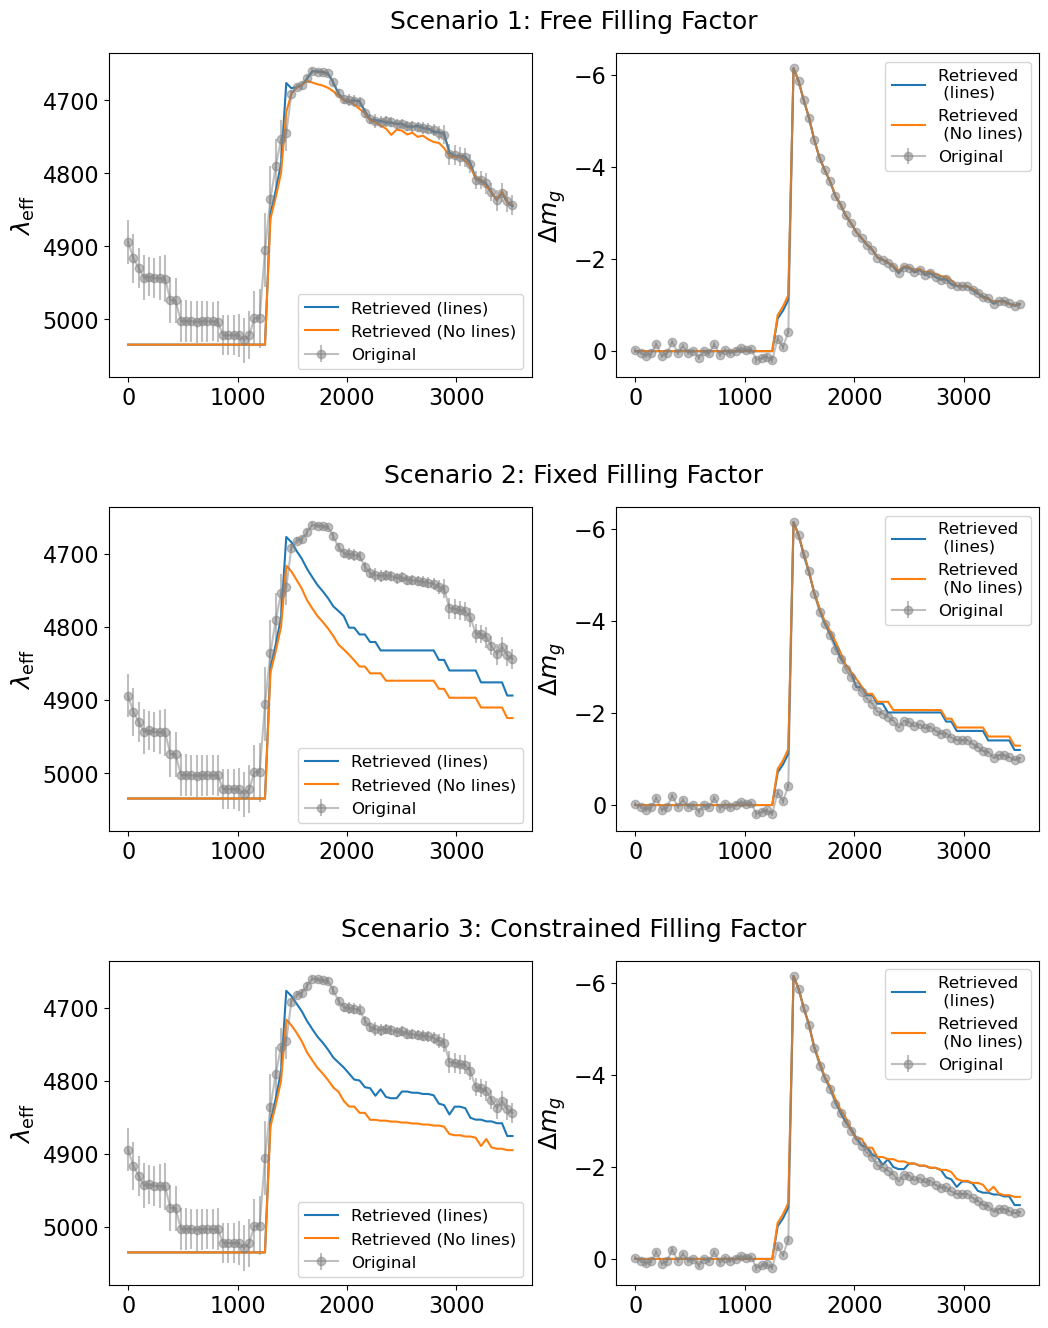

In [128]:
fig, axes = plt.subplots(3,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4)
ax = axes.flatten()

for i in range(3):
    j = i * 2
    ax[j].errorbar(tSec, flr_weffs, yerr = weffErrRadec, alpha = 0.5, c='grey', marker='o', label='Original')
    ax[j].plot(tSec, np.load(f'Outdata/retrived_weffs{i+1}_lines.npy'), label='Retrieved (lines)')
    ax[j].plot(tSec, np.load(f'Outdata/retrived_weffs{i+1}_nolines.npy'), label='Retrieved (No lines)')
    ax[j].set_ylabel(r'$\lambda_\mathrm{eff}$')
    ax[j].invert_yaxis()
    ax[j].legend(loc = 'lower right', fontsize=8)
    
    ax[j+1].plot(tSec, np.load(f'Outdata/retrived_mags{i+1}_lines.npy'), label='Retrieved \n (lines)')
    ax[j+1].plot(tSec, np.load(f'Outdata/retrived_mags{i+1}_nolines.npy'), label='Retrieved \n (No lines)')
    ax[j+1].errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err, alpha = 0.5, c='grey', marker='o', label='Original')
    ax[j+1].set_ylabel(r'$\Delta m_g$')
    ax[j+1].invert_yaxis()
    ax[j+1].legend(loc = 'lower right', fontsize=8)

ax[0].set_title('Scenario 1: Free Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[2].set_title('Scenario 2: Fixed Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[4].set_title('Scenario 3: Constrained Filling Factor', x=1.1, y=1.05, fontsize=18)

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)

    if i % 2 == 0:
        a.legend(loc = 'lower right', fontsize=12)
    else:
        a.legend(loc = 'upper right', fontsize=12)

fig.savefig('Figures/retrieval.png', dpi=300, bbox_inches='tight')

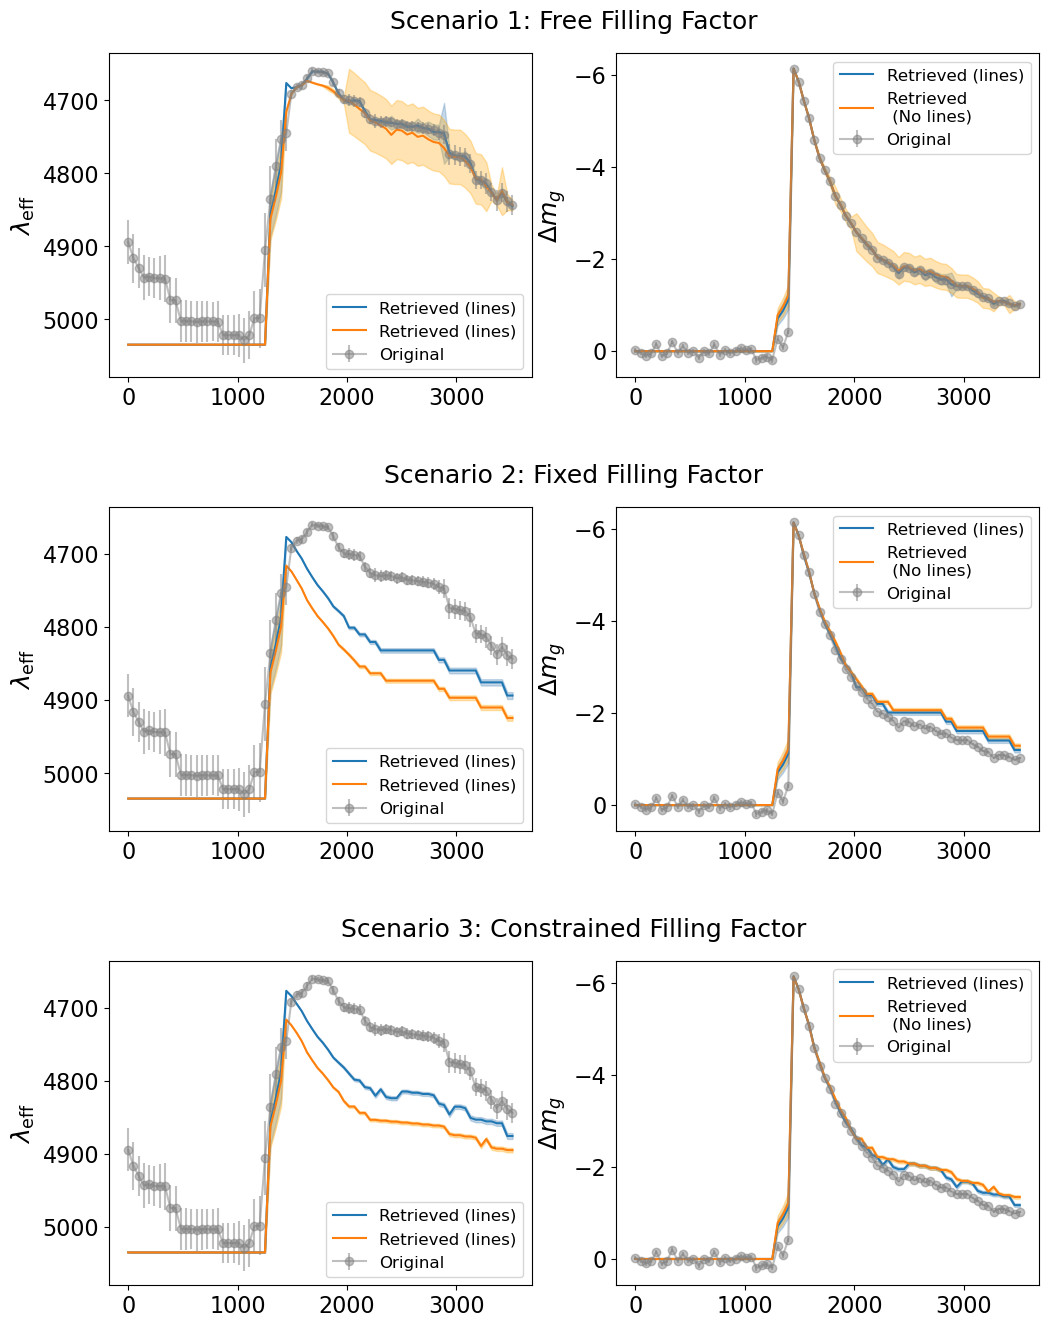

In [134]:
#now with uncerainties

fig, axes = plt.subplots(3,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4)
ax = axes.flatten()


for i in range(3):
    j = i * 2
    ax[j].errorbar(tSec, flr_weffs, yerr = weffErrRadec, alpha = 0.5, c='grey', marker='o', label='Original')
    quant = np.load(f'Outdata/retrived_weffs{i+1}_lines.npy')
    unc = pd.read_csv(f"Outdata/uncertaities_weff_retrievedScenario{i+1}.csv")
    ax[j].plot(tSec, quant, label='Retrieved (lines)')
    ax[j].fill_between(tSec, quant + unc['lines'].values, quant - unc['lines'].values,  color='SteelBlue', alpha=0.3)
    quant = np.load(f'Outdata/retrived_weffs{i+1}_nolines.npy')
    ax[j].plot(tSec, quant, label='Retrieved (lines)')
    ax[j].fill_between(tSec, quant + unc['nolines'].values, quant - unc['nolines'].values,  color='orange', alpha=0.3)
    ax[j].set_ylabel(r'$\lambda_\mathrm{eff}$')
    ax[j].invert_yaxis()
    ax[j].legend(loc = 'lower right', fontsize=8)

    ax[j+1].errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err, alpha = 0.5, c='grey', marker='o', label='Original')
    quant = np.load(f'Outdata/retrived_mags{i+1}_lines.npy')
    unc = pd.read_csv(f"Outdata/uncertaities_mag_retrievedScenario{i+1}.csv")
    ax[j+1].plot(tSec, quant, label='Retrieved (lines)')
    ax[j+1].fill_between(tSec, quant + unc['lines'].values, quant - unc['lines'].values,  color='SteelBlue', alpha=0.3)
    quant = np.load(f'Outdata/retrived_mags{i+1}_nolines.npy')
    ax[j+1].plot(tSec, quant, label='Retrieved \n (No lines)')
    ax[j+1].fill_between(tSec, quant + unc['nolines'].values, quant - unc['nolines'].values,  color='orange', alpha=0.3)
    ax[j+1].set_ylabel(r'$\Delta m_g$')
    ax[j+1].invert_yaxis()
    ax[j+1].legend(loc = 'lower right', fontsize=8)


ax[0].set_title('Scenario 1: Free Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[2].set_title('Scenario 2: Fixed Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[4].set_title('Scenario 3: Constrained Filling Factor', x=1.1, y=1.05, fontsize=18)

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)

    if i % 2 == 0:
        a.legend(loc = 'lower right', fontsize=12)
    else:
        a.legend(loc = 'upper right', fontsize=12)

fig.savefig('Figures/retrieval.png', dpi=300, bbox_inches='tight')

# put together grid abd bootstrap in quadrature (??!?)

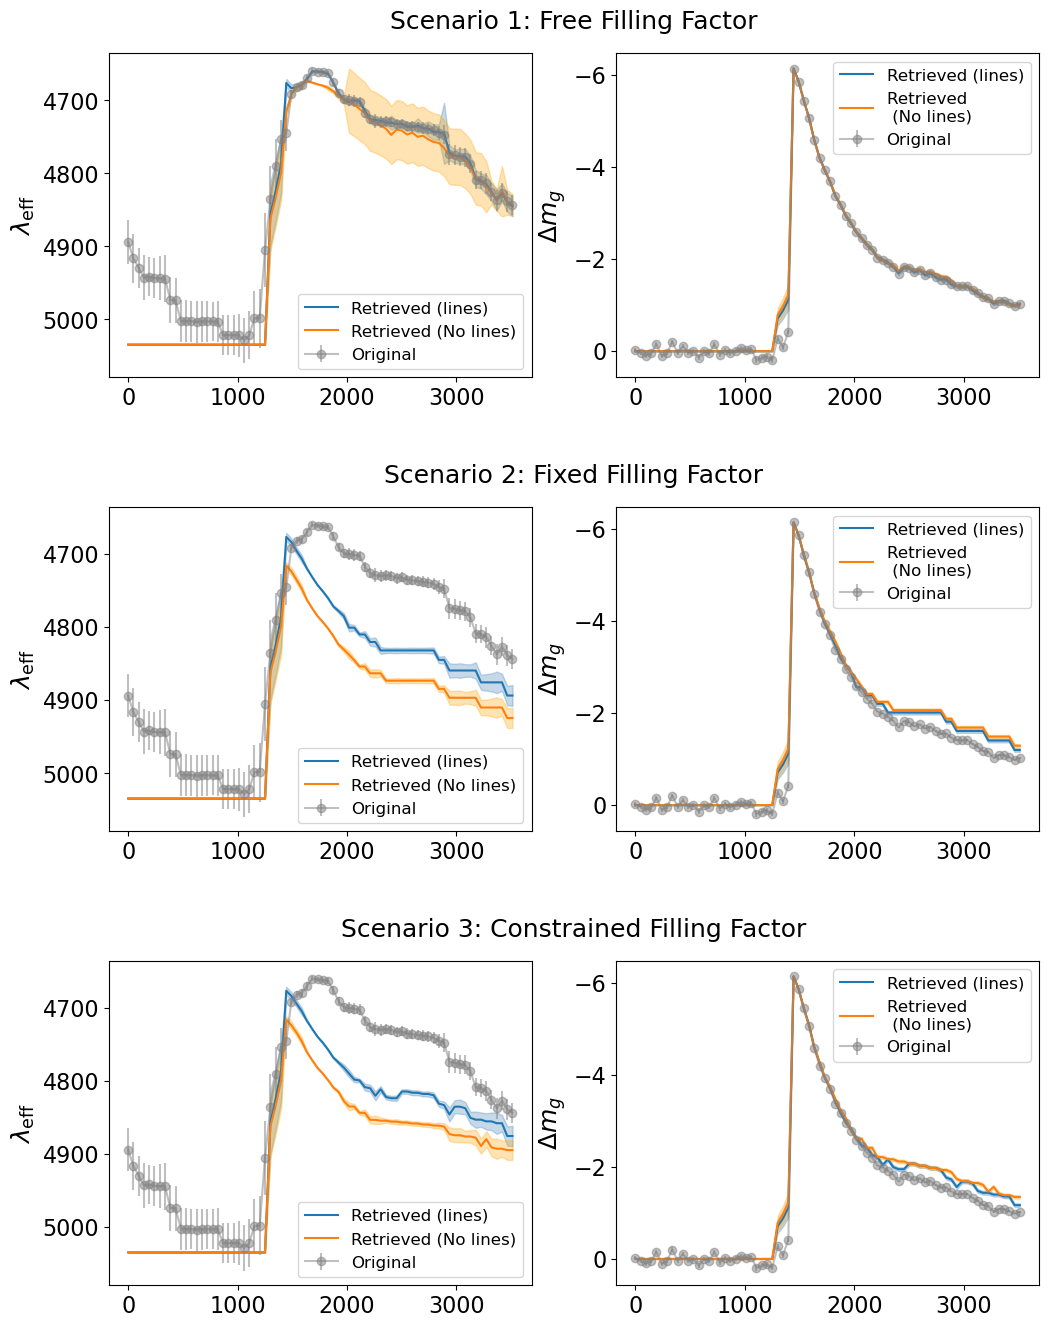

In [139]:
#now with uncerainties

fig, axes = plt.subplots(3,2,figsize=(12,16))
fig.subplots_adjust(hspace=0.4)
ax = axes.flatten()


for i in range(3):
    j = i * 2
    
    unc_grid = pd.read_csv(f"Outdata/uncertaities_weff_retrievedScenario{i+1}.csv")
    unc_bootstrap = pd.read_csv(f"Outdata/model_weff_errs{s}.csv")
    quant = np.load(f'Outdata/retrived_weffs{i+1}_lines.npy')
    
    unf_full = np.sqrt(unc_bootstrap['lines'].values**2 + unc_grid['lines'].values**2)
    
    ax[j].errorbar(tSec, flr_weffs, yerr = weffErrRadec, alpha = 0.5, c='grey', marker='o', label='Original')
    ax[j].plot(tSec, quant, label='Retrieved (lines)')
    ax[j].fill_between(tSec, quant + unf_full, quant - unf_full,  color='SteelBlue', alpha=0.3)
    
    quant = np.load(f'Outdata/retrived_weffs{i+1}_nolines.npy')
    unf_full = np.sqrt(unc_bootstrap['nolines'].values**2 + unc_grid['nolines'].values**2)

    ax[j].plot(tSec, quant, label='Retrieved (No lines)')
    ax[j].fill_between(tSec, quant + unf_full, quant - unf_full,  color='orange', alpha=0.3)
    ax[j].set_ylabel(r'$\lambda_\mathrm{eff}$')
    ax[j].invert_yaxis()
    ax[j].legend(loc = 'lower right', fontsize=8)

    unc_grid = pd.read_csv(f'Outdata/uncertaities_mag_retrievedScenario{i+1}.csv')
    unc_bootstrap = pd.read_csv(f"Outdata/model_mag_errs{s}.csv")
    quant = np.load(f'Outdata/retrived_mags{i+1}_lines.npy')
    
    ax[j+1].errorbar(tSec, delta_g_mag, yerr=delta_g_mag_err, alpha = 0.5, c='grey', marker='o', label='Original')
    ax[j+1].plot(tSec, quant, label='Retrieved (lines)')
    ax[j+1].fill_between(tSec, quant + unc['lines'].values, quant - unc['lines'].values,  color='SteelBlue', alpha=0.3)
    
    quant = np.load(f'Outdata/retrived_mags{i+1}_nolines.npy')
    unf_full = np.sqrt(unc_bootstrap['nolines'].values**2 + unc_grid['nolines'].values**2)

    ax[j+1].plot(tSec, quant, label='Retrieved \n (No lines)')
    ax[j+1].fill_between(tSec, quant + unc['nolines'].values, quant - unc['nolines'].values,  color='orange', alpha=0.3)
    ax[j+1].set_ylabel(r'$\Delta m_g$')
    ax[j+1].invert_yaxis()
    ax[j+1].legend(loc = 'lower right', fontsize=8)


ax[0].set_title('Scenario 1: Free Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[2].set_title('Scenario 2: Fixed Filling Factor', x=1.1, y=1.05, fontsize=18)
ax[4].set_title('Scenario 3: Constrained Filling Factor', x=1.1, y=1.05, fontsize=18)

for i, a in enumerate(ax):
    a.tick_params(axis='both', labelsize=16)
    a.xaxis.get_label().set_fontsize(18)
    a.yaxis.get_label().set_fontsize(18)

    if i % 2 == 0:
        a.legend(loc = 'lower right', fontsize=12)
    else:
        a.legend(loc = 'upper right', fontsize=12)

fig.savefig('Figures/retrieval.png', dpi=300, bbox_inches='tight')